In [47]:
# Use Python 3.6, networkx 1.11
# Necessary...
import csv # to read CSV file
import networkx as nx # to make and analyze networks/graphs
import unicodedata # to compare strings while ignoring case
import matplotlib.pyplot as plt # to draw figures
from matplotlib.pyplot import figure # to draw figures
from tabulate import tabulate # to display markdown-compatible tables
import operator # to make sorting easier, using .itemgetter
import copy # to make deep copies of lists and such
from copy import deepcopy
import random
import string

# Function to ignore case, when searching for occurrences of definiendum and short definiendum in definiens.
def normalize_caseless(text):
    return unicodedata.normalize("NFKD", text.casefold())

# Function to make a list with as many random colors as number_of_colors.
def make_edge_colors(number_of_colors):
    color_list = list()
    color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    return color_list

# Function to draw a sub-network of your_network, such that:
# it includes only edges which have, in your_network, the value your_edge_attribute_value for attribute your_edge_attribute, and
# it includes only nodes from your_network, which are connected by the edges selected above, and
# each node is labeled by the value of its your_node_attribute, from your_network.
def draw_your_subnetwork(your_network, your_node_attribute, your_edge_attribute, your_edge_attribute_value):
    plt.figure(num=None, figsize=(10, 10), dpi=60, facecolor='w', edgecolor='g')
    pos = nx.spring_layout(your_network, k=20)
#     pos = nx.spectral_layout(your_network)

    ## Select subset of nodes and edges to draw.
    nodes_to_draw = list()
    edges_to_draw = list()
    for o,d in your_network.edges():
        if nx.get_edge_attributes(your_network, your_edge_attribute)[o,d] == your_edge_attribute_value:
            if o not in nodes_to_draw: nodes_to_draw.append(o)
            if d not in nodes_to_draw: nodes_to_draw.append(d)
            edges_to_draw.append((o,d))

    ## Make labels for nodes to draw, cut to 15 characters if label longer than 10.
    all_node_labels = nx.get_node_attributes(your_network, your_node_attribute)
    node_labels_short = dict()
    for n in nodes_to_draw:
        if len(all_node_labels[n]) < 9: node_labels_short[n] = all_node_labels[n]
        else: node_labels_short[n] = all_node_labels[n][0:15] + '...'

    ## Make colors for edges.
    colors = make_edge_colors(len(your_network.nodes()))
    ### Assign a color to each node.
    node_colors = dict()
    j = 0
    for i in nodes_to_draw: 
        node_colors[i] = colors[j]
        j = j + 1
    ### Give each edge the color of its target node.
    edge_colors = list()
    node_color_list = list()
    for o,d in edges_to_draw:
        edge_colors.append(node_colors[d])
    
#     node_color_list = list()
#     for n in nodes_to_draw:
#         node_color_list.append(node_colors[n])
    
    ## Draw the network and save as PNG image.
    nx.draw(your_network, pos, node_list = nodes_to_draw, edgelist = edges_to_draw, 
            labels = node_labels_short, arrows=True, with_labels=True, 
            node_color='#FFFFFF', edge_color=edge_colors)
    image_file_name = "%s_%s.png" % (analysis_project_name, your_edge_attribute_value)
    plt.savefig(image_file_name)
    print('Sub-network image filename:', image_file_name)
    print('Nodes in sub-network:', len(nodes_to_draw))
    print('Edges in sub-network:', len(edges_to_draw))

In [2]:
# Set the name of the project, to use as prefix on names of all output files.

## Project: UN Glossary of World Heritage Terms
# analysis_project_name = "UN_GWHT_TDN" 
# analysis_project_data_file = "ilang_UN_GWHT_terminology_raw - Sheet1.csv"

## Project: Smart Retail Network
analysis_project_name = "SRN_DN" 
analysis_project_data_file = "raw_data/ilang_SRN_data.csv"

In [3]:
# Get raw definitions from a CSV file
# Create empty raw_definitions, to hold definiendum, short definiendum (abbreviation of definiens), and definiens.
raw_definitions = []
# Fill raw_definitions as a list of triples, where a triple includes the definiendum, short definiendum, and definiens.
with open(analysis_project_data_file) as raw_definitions_file:
    raw_definitions_csv = csv.reader(raw_definitions_file, delimiter = ',')
    for row in raw_definitions_csv:
        raw_definitions.append({'definiendum':row[0], 'short definiendum':row[1], 'definiens':row[2]})

In [4]:
# Remove the column title row from raw_definitions.
raw_defs = [(raw_definitions[i]) for i in range(1,len(raw_definitions))]

In [5]:
### Definition Network

# Make an empty Definition Network.
dn = nx.DiGraph()

## Populate Definition Network with nodes.

# Make a random 10-item alphanumeric string, to use in node identifiers.
def id_generator(size=10, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

# Checks if node_id is unique among node_id values which are already in a network.
def is_unique_node_id(network, node_identifier):
    j = 0
    for i in network.nodes():
        if node_identifier == i: j = j + 1
    return j

# Make 2*len(raw_defs)+2 nodes, give each a unique node_id (unique in the given network only).
# node_id has format node_[random 8 characters].
for i in range(0, 2*len(raw_defs)+2):
    node_id = analysis_project_name + '_node_' + id_generator()
    if is_unique_node_id(dn, node_id) == 0:
        dn.add_node(node_id)

In [6]:
## Label all Definition Network nodes.
# Put definientia, definienda, Definiendum, and Definiens node labels in a list.
node_content_list = list()
[ node_content_list.append(raw_defs[i][j]) for j in { 'definiendum', 'definiens' } for i in range(0, len(raw_defs))]
node_content_list.append('Definiendum')
node_content_list.append('Definiens')

# Make a dictionary of (node_id, node content value) pairs.
node_content_dict = dict()
for i in range(0, len(dn.nodes())):
    node_content_dict[list(dn.nodes())[i]] = node_content_list[i]

# Set node 'content' attribute using node_content_dict.
nx.set_node_attributes(dn, name = 'content', values = node_content_dict)

In [7]:
# Given a network, an attribute, and a value of attribute, 
# returns node_id of the node, which has that attribute value.
def attribute_value_node_id(network, attribute, value):
    result = None
    for i in nx.get_node_attributes(network, attribute):
        if nx.get_node_attributes(network, attribute)[i] == value: result = i
    if result == None: return 'No node for that attribute value'
    else: return result

In [8]:
## Populate network with Is-a relationship edges.
for i in dn.nodes():
    for j in range(0, len(raw_defs)):
        if raw_defs[j]['definiens'] == nx.get_node_attributes(dn, 'content')[i]:
            dn.add_edge(i, attribute_value_node_id(dn, 'content', 'Definiens'), relationship = 'Is-a')
        if raw_defs[j]['definiendum'] == nx.get_node_attributes(dn, 'content')[i]:
            dn.add_edge(i, attribute_value_node_id(dn, 'content', 'Definiendum'), relationship = 'Is-a')

In [9]:
## Populate network with Defines relationship edges.
for i in range(0, len(raw_defs)):
        dn.add_edge(attribute_value_node_id(dn, 'content', raw_defs[i]['definiens']), attribute_value_node_id(dn, 'content', raw_defs[i]['definiendum']), relationship = 'Defines')    

Sub-network image filename: SRN_DN_Is-a.png
Nodes in sub-network: 32
Edges in sub-network: 30


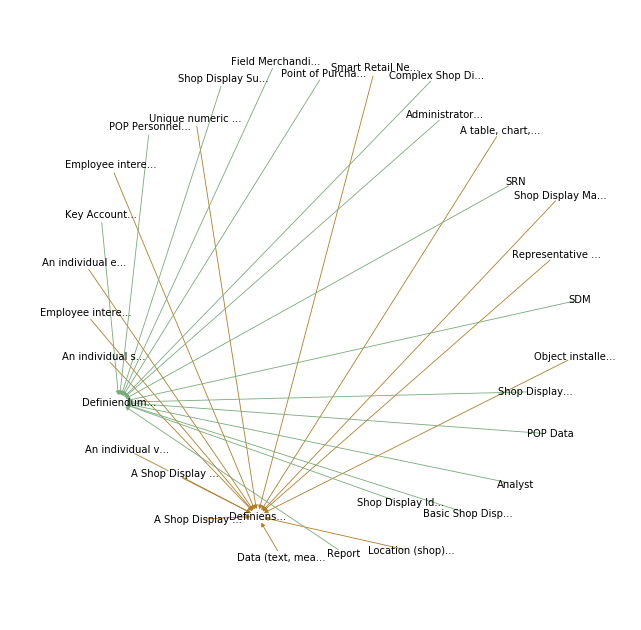

In [49]:
# Plot the Is-a sub-network.
draw_your_subnetwork(dn, 'content', 'relationship', 'Is-a')

Sub-network image filename: SRN_DN_Defines.png
Nodes in sub-network: 30
Edges in sub-network: 15


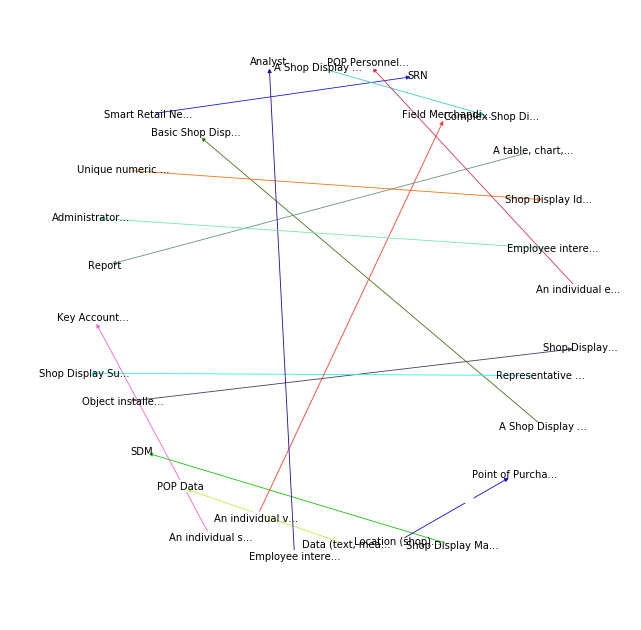

In [48]:
# Plot the Defines sub-network.
draw_your_subnetwork(dn, 'content', 'relationship', 'Defines')

In [50]:
# Function to draw a sub-network of your_network, such that:
# it includes only edges which have, in your_network, the value your_edge_attribute_value for attribute your_edge_attribute, and
# it includes only nodes from your_network, which are connected by the edges selected above, and
# each node is labeled by the value of its your_node_attribute, from your_network.
def draw_your_subnetwork_2(your_network, your_node_attribute, your_edge_attribute, your_edge_attribute_value):
    plt.figure(num=None, figsize=(10, 10), dpi=60, facecolor='w', edgecolor='g')
    pos = nx.spring_layout(your_network, k=20)
#     pos = nx.spectral_layout(your_network)

    ## Select subset of nodes and edges to draw.
    nodes_to_draw = list()
    edges_to_draw = list()
    for o,d in your_network.edges():
        if nx.get_edge_attributes(your_network, your_edge_attribute)[o,d] == your_edge_attribute_value:
            if o not in nodes_to_draw: nodes_to_draw.append(o)
            if d not in nodes_to_draw: nodes_to_draw.append(d)
            edges_to_draw.append((o,d))

    ## Make labels for nodes to draw, cut to 15 characters if label longer than 10.
    all_node_labels = nx.get_node_attributes(your_network, your_node_attribute)
    node_labels_short = dict()
    for n in nodes_to_draw:
        if len(all_node_labels[n]) < 9: node_labels_short[n] = all_node_labels[n]
        else: node_labels_short[n] = all_node_labels[n][0:15] + '...'

    ## Make colors for edges.
    colors = make_edge_colors(len(your_network.nodes()))
    ### Assign a color to each node.
    node_colors = dict()
    j = 0
    for i in nodes_to_draw: 
        node_colors[i] = colors[j]
        j = j + 1
    ### Give each edge the color of its target node.
    edge_colors = list()
    node_color_list = list()
    for o,d in edges_to_draw:
        edge_colors.append(node_colors[d])
    
#     node_color_list = list()
#     for n in nodes_to_draw:
#         node_color_list.append(node_colors[n])
    
    ## Draw the network and save as PNG image.
    nx.draw(your_network, pos, node_list = nodes_to_draw, edgelist = edges_to_draw, 
            labels = node_labels_short, arrows=True, with_labels=True, 
            node_color='#FFFFFF', edge_color=edge_colors)
    image_file_name = "%s_%s.png" % (analysis_project_name, your_edge_attribute_value)
    plt.savefig(image_file_name)
    print('Sub-network image filename:', image_file_name)
    print('Nodes in sub-network:', len(nodes_to_draw))
    print('Edges in sub-network:', len(edges_to_draw))
    print(nodes_to_draw)

Sub-network image filename: SRN_DN_Is-a.png
Nodes in sub-network: 32
Edges in sub-network: 30
['SRN_DN_node_3QKEHDLMS2', 'SRN_DN_node_JNXC3YLLDJ', 'SRN_DN_node_TOH8SWXDCR', 'SRN_DN_node_0U029SYGL7', 'SRN_DN_node_B5OR4FP9ZB', 'SRN_DN_node_MZVHTEON4C', 'SRN_DN_node_E6L4G6WZ35', 'SRN_DN_node_67ZF28SY3W', 'SRN_DN_node_G1TCLOPRA9', 'SRN_DN_node_UAT2HE78KF', 'SRN_DN_node_WR3WCDAFTP', 'SRN_DN_node_GL97V4C8RV', 'SRN_DN_node_0P33QNOIDL', 'SRN_DN_node_Y7VET1R4E2', 'SRN_DN_node_ZD2UEI5LUD', 'SRN_DN_node_QOV98YDE2Y', 'SRN_DN_node_85172HEMVE', 'SRN_DN_node_ZHKU8OZ93H', 'SRN_DN_node_ZXL5XO2679', 'SRN_DN_node_FL1OOYGUQP', 'SRN_DN_node_UFJ037IG45', 'SRN_DN_node_WHRQ31EFCZ', 'SRN_DN_node_31FHLTUX9F', 'SRN_DN_node_1TB99YVXTS', 'SRN_DN_node_SOPZG06DIH', 'SRN_DN_node_Q3F8V7H5YD', 'SRN_DN_node_HFTQ8KSFK8', 'SRN_DN_node_Y7CHJZAXMV', 'SRN_DN_node_BJ0Y7AVJI6', 'SRN_DN_node_4YUOWAHEGZ', 'SRN_DN_node_XPQKNXG12D', 'SRN_DN_node_REAWYYZSWI']


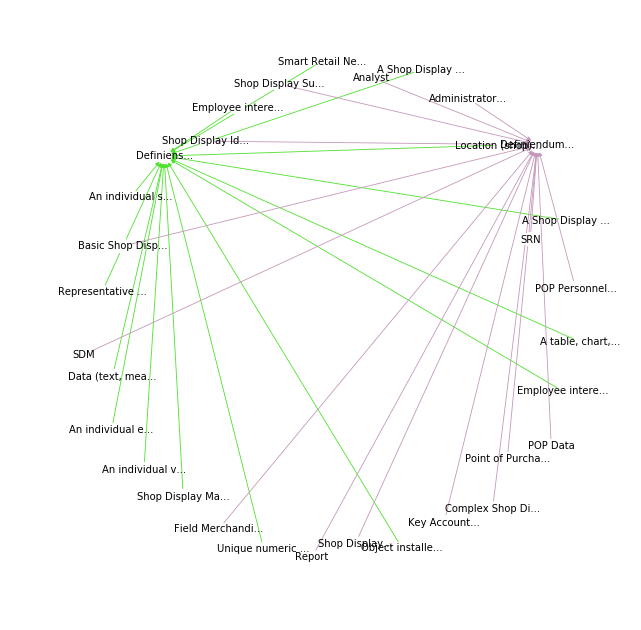

In [51]:
draw_your_subnetwork_2(dn, 'content', 'relationship', 'Is-a')

In [ ]:
print(nx.get_node_attributes)